In [1]:
def get_station_names():
    
    names = open("stations.txt", 'r').readlines()
    clean_names = []
    for name in names:
        clean_names.append(name.replace("\n", ""))
        
    return clean_names

stations = get_station_names()

In [2]:
def get_lat_long_text(station):
    '''
    Get the lines containing the latitude and longitude information
    of the station
    '''
    lines = open("data\\"+station+".txt", "r").readlines()
    text = ""
    
    for line in lines:
        if "Lat" in line:
            text = line
            break
            
    return text
 

In [3]:
for station in stations:
    print(station, get_lat_long_text(station))

aberporth Location: 224100E 252100N, Lat 52.139 Lon -4.570, 133 metres amsl

armagh Location: 287800E 345800N (Irish Grid), Lat 54.352 Lon -6.649, 62 metres amsl

ballypatrick Location 317600E 438600N (Irish Grid), Lat 55.181 Lon -6.153, 156m amsl

bradford Location 414900E 435200N, Lat 53.813 Lon -1.772, 134 metres amsl

braemar & 315200E 791900N, Lat 57.006 Lon -3.396, 327 metres amsl (Aug 2005 onwards)

camborne Location 162700E 40700N, Lat 50.218 Lon -5.327, 87m amsl

cambridge Location: 543500E 260600N, Lat 52.245 Lon 0.102, 26 metres amsl

cardiff Location 317600E 177300N, Lat 51.488 Lon -3.187, 9 metres amsl

chivenor Location 249600E 134400N, Lat 51.089 Lon -4.147, 6m amsl

cwmystwyth Location: 277300E 274900N, Lat 52.358 Lon -3.802, 301 metres amsl

dunstaffnage Location 188100E 734000N, Lat 56.451 Lon -5.439, 3m amsl

durham Location: 426700E 541500N, Lat 54.768 Lon -1.585, 102 metres amsl

eastbourne Location: 561100E 98300N, Lat 50.762 Lon 0.285, 7 metres amsl

eskdalemuir 

In [4]:
def parse_line(line):
    '''
    Extract latitude and longitude data from a line entry
    '''
    tokens = line.split(" ")
    lat_long = []
    
    for i in range(0, len(tokens)):
        
        if "Lat" in tokens[i]:
            lat_long.append(tokens[i+1].strip().replace(",",""))
        elif "Lon" in tokens[i]:
            lat_long.append(tokens[i+1].strip().replace(",",""))
        else:
            pass
        
        if len(lat_long) >= 2:
            break
            
    return lat_long

In [5]:
import pandas as pd

def get_lat_long():
    "Extract latitude longitude data and store it in a data frame"
    locations = {}
    for station in stations:
        lat_long = parse_line(get_lat_long_text(station))
        locations[station] = lat_long
    
    return pd.DataFrame(locations, index=["latitude", "longitude"]).transpose()
    

In [19]:
coordinates = get_lat_long()
coordinates.latitude = coordinates.latitude.astype(float)
coordinates.longitude = coordinates.longitude.astype(float)
coordinates

,latitude,longitude
aberporth,52.139,-4.570
armagh,54.352,-6.649
ballypatrick,55.181,-6.153
bradford,53.813,-1.772
braemar,57.006,-3.396
camborne,50.218,-5.327
cambridge,52.245,0.102
cardiff,51.488,-3.187
chivenor,51.089,-4.147
cwmystwyth,52.358,-3.802


## create true class labels for the station data

In [20]:
coordinates = pd.concat([coordinates, pd.Series(name="label", index=coordinates.index)], axis=1)
n_cutoff = 57.233 # latitude boundary between northern and central thirds
s_cutoff = 53.567 # latitude boundary between central and southern thirds

for index in range(0, len(coordinates)):
    
    if coordinates.latitude.iloc[index] < s_cutoff:
        # located in southrern third
        coordinates.iat[index, 2] = -1
        
    elif coordinates.latitude.iloc[index] > n_cutoff:
        # located in northern third
        coordinates.iat[index, 2] = 1
        
    else:
        # located in central third
        coordinates.iat[index, 2] = 0
        

## store labled data in monogodb data base server

In [9]:
from pymongo import MongoClient

def make_lineObj(line, data):
    
    # create mongo document object
    return {
        "station" :  data.index[line],
        "latitude" : data.latitude.iloc[line],
        "longitude" : data.longitude.iloc[line],
        "label" : data.label.iloc[line],
    }

def storeObj(obj):
    collection = "station_cordinates"
    
    # Config database server
    client = MongoClient(host="midgard09", port=27017)
    db = client.pitds_weather_data
    weather_data = db[collection]
    
    # Store document
    weather_data.insert_one(obj)
    print("successfully stored: ", obj["station"])
    
    
for row in range(0, len(coordinates)):
    storeObj(make_lineObj(row, coordinates))

successfully stored:  aberporth
successfully stored:  armagh
successfully stored:  ballypatrick
successfully stored:  bradford
successfully stored:  braemar
successfully stored:  camborne
successfully stored:  cambridge
successfully stored:  cardiff
successfully stored:  chivenor
successfully stored:  cwmystwyth
successfully stored:  dunstaffnage
successfully stored:  durham
successfully stored:  eastbourne
successfully stored:  eskdalemuir
successfully stored:  heathrow
successfully stored:  hurn
successfully stored:  lerwick
successfully stored:  leuchars
successfully stored:  lowestoft
successfully stored:  manston
successfully stored:  nairn
successfully stored:  newtonrigg
successfully stored:  oxford
successfully stored:  paisley
successfully stored:  ringway
successfully stored:  rossonwye
successfully stored:  shawbury
successfully stored:  sheffield
successfully stored:  southampton
successfully stored:  stornoway
successfully stored:  suttonbonington
successfully stored:  tir

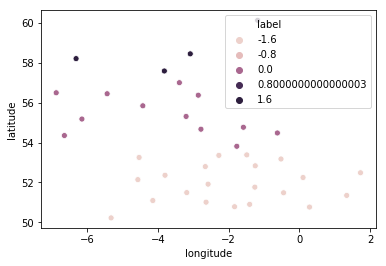

In [21]:
import seaborn as sns
sns.scatterplot(data=coordinates, x="longitude", y="latitude", hue="label")